In [ ]:
import pandas as pd
import numpy as np
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import csv
import string
import os
import sklearn
import matplotlib.pyplot as plt
import numpy
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from sklearn.preprocessing import label_binarize

In [ ]:
MAX_SIZE = 200

In [ ]:
path = '/content/drive/MyDrive/NN_Labs/drugLib_raw'

In [ ]:
BATCH_SIZE = 64

In [ ]:
def read_data(path, is_train):
    data, rating, effectiveness, sideEffects = [], [], [], []
    file = os.path.join(path, 'drugLibTrain_raw.tsv' if is_train else 'drugLibTest_raw.tsv')
    with open(file, 'r') as f:
            tsvreader = csv.reader(f, delimiter="\t")
            for line in tsvreader:
                review = line[8].replace('\n', '').translate(str.maketrans('', '', string.punctuation))
                review += line[6].replace('\n', '').translate(str.maketrans('', '', string.punctuation))
                review += line[7].replace('\n', '').translate(str.maketrans('', '', string.punctuation))
                data.append(review)
                rating.append(line[2])
                effectiveness.append(line[3])
                sideEffects.append(line[4])
    return data, rating, effectiveness, sideEffects

In [ ]:
def cutter(size, a):
  ln = int(size/BATCH_SIZE)*BATCH_SIZE
  a = a[:ln]
  return a

In [ ]:
reviews_list, rating, effectiveness, sideEffects = read_data(path, is_train=True)
reviews_list.pop(0)
rating.pop(0)
effectiveness.pop(0)
sideEffects.pop(0)

'sideEffects'

In [ ]:
def inverse(matrix):
  listt = []
  for arr in matrix:
    listt.append(np.argmax(arr))
  return listt

In [ ]:

def report(history, y_true_matrix, y_pred_matrix):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    y_true = inverse(y_true_matrix)
    y_pred = inverse(y_pred_matrix)
    print("accuracy_score is  {:.2f}%".format(sklearn.metrics.accuracy_score(y_true, y_pred)*100))
    print("balanced_accuracy_score is  {:.2f}%".format(sklearn.metrics.balanced_accuracy_score(y_true, y_pred)*100))
    print("f1_score is  {:.2f}%".format(sklearn.metrics.f1_score(y_true, y_pred, average='weighted')*100))
    print("roc_auc_score is  {:.2f}%".format(sklearn.metrics.roc_auc_score(y_true_matrix, y_pred_matrix, average='weighted', multi_class='ovo')*100))
    print("recall_score is  {:.2f}%".format(sklearn.metrics.recall_score(y_true, y_pred, average='weighted')*100))
    print("precision_score is  {:.2f}%".format(sklearn.metrics.precision_score(y_true, y_pred, average='weighted')*100))
    print()

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

word_to_vec_map = read_glove_vector('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt')

In [ ]:
def lstm(vocab_len, emb_matrix):
  model = Sequential()
  model.add(Embedding(input_dim=vocab_len, output_dim=100, weights=[emb_matrix], trainable=False, mask_zero=True))
  model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  opt = tf.keras.optimizers.SGD(learning_rate = 0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def rnn():
  model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])
  
  opt = tf.keras.optimizers.SGD(learning_rate = 0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
def gru():
  model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])
  
  opt = tf.keras.optimizers.SGD(learning_rate = 0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
rating = [int(i)-1 for i in rating]
y = np.array(list(map(lambda x: 2 if x>=7 else 1 if 3<x<7 else 0, rating)))

In [ ]:
train_un = np.unique(y)
ya = label_binarize(y, classes=train_un)

In [ ]:
ya.shape

(3107, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_list, ya, test_size=0.2, random_state = 45)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
len(words_to_index)

17894

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=MAX_SIZE, weights = [emb_matrix], trainable=False)

In [ ]:
import tensorflow as tf

model = lstm(vocab_len, emb_matrix)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         1789400   
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,835,995
Trainable params: 46,595
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=MAX_SIZE, padding='post')

X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_SIZE, padding='post')

In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 19s 408ms/step - loss: 1.1071 - accuracy: 0.2889 - val_loss: 1.0920 - val_accuracy: 0.3473
Epoch 2/5
39/39 [==============================] - 16s 417ms/step - loss: 1.0730 - accuracy: 0.4652 - val_loss: 1.0624 - val_accuracy: 0.5418
Epoch 3/5
39/39 [==============================] - 15s 396ms/step - loss: 1.0490 - accuracy: 0.5461 - val_loss: 1.0411 - val_accuracy: 0.5659
Epoch 4/5
39/39 [==============================] - 15s 396ms/step - loss: 1.0302 - accuracy: 0.5706 - val_loss: 1.0255 - val_accuracy: 0.5707
Epoch 5/5
39/39 [==============================] - 15s 393ms/step - loss: 1.0177 - accuracy: 0.5722 - val_loss: 1.0137 - val_accuracy: 0.5740


In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_SIZE, padding='post')

model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 44ms/step - loss: 1.0137 - accuracy: 0.5740


[1.0137265920639038, 0.5739549994468689]

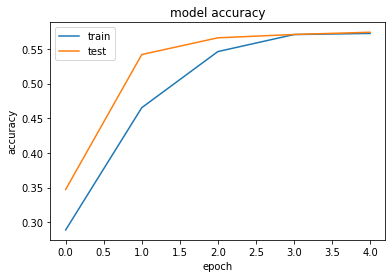

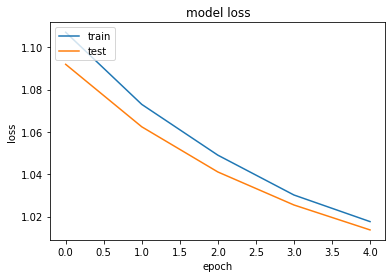

accuracy_score is  57.40%
balanced_accuracy_score is  33.24%
f1_score is  41.98%
roc_auc_score is  50.82%
recall_score is  57.40%
precision_score is  33.09%



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# **Simple RNN**

In [ ]:
model = rnn()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1792200   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
 dense_14 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,796,819
Trainable params: 4,619
Non-trainable params: 1,792,200
_________________________________________________________________


In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 4s 58ms/step - loss: 0.9870 - accuracy: 0.5725 - val_loss: 0.9936 - val_accuracy: 0.5707
Epoch 2/5
39/39 [==============================] - 2s 51ms/step - loss: 0.9839 - accuracy: 0.5725 - val_loss: 0.9806 - val_accuracy: 0.5707
Epoch 3/5
39/39 [==============================] - 2s 53ms/step - loss: 0.9789 - accuracy: 0.5729 - val_loss: 0.9802 - val_accuracy: 0.5707
Epoch 4/5
39/39 [==============================] - 2s 51ms/step - loss: 0.9769 - accuracy: 0.5749 - val_loss: 0.9858 - val_accuracy: 0.5691
Epoch 5/5
39/39 [==============================] - 2s 50ms/step - loss: 0.9766 - accuracy: 0.5745 - val_loss: 0.9807 - val_accuracy: 0.5707


In [ ]:
model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 24ms/step - loss: 0.9807 - accuracy: 0.5707


[0.980650007724762, 0.5707395672798157]

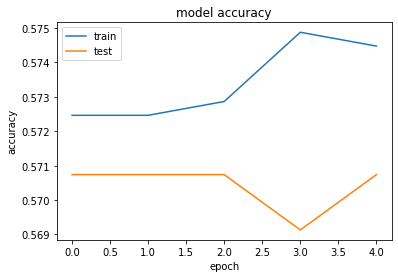

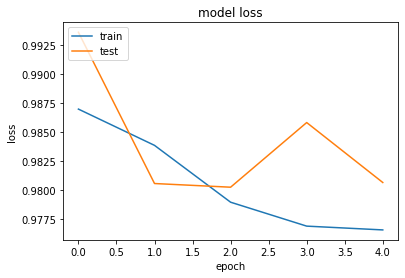

accuracy_score is  57.07%
balanced_accuracy_score is  33.15%
f1_score is  41.71%
roc_auc_score is  51.34%
recall_score is  57.07%
precision_score is  32.86%



In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# **GRU**

In [ ]:
model = gru()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1792200   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               25728     
 l)                                                              
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
 dense_16 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,818,611
Trainable params: 26,411
Non-trainable params: 1,792,200
_________________________________________________________________


In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 16s 294ms/step - loss: 1.0171 - accuracy: 0.5399 - val_loss: 0.9821 - val_accuracy: 0.5691
Epoch 2/5
39/39 [==============================] - 9s 243ms/step - loss: 0.9793 - accuracy: 0.5721 - val_loss: 0.9852 - val_accuracy: 0.5691
Epoch 3/5
39/39 [==============================] - 10s 254ms/step - loss: 0.9732 - accuracy: 0.5745 - val_loss: 0.9811 - val_accuracy: 0.5691
Epoch 4/5
39/39 [==============================] - 10s 254ms/step - loss: 0.9716 - accuracy: 0.5749 - val_loss: 0.9821 - val_accuracy: 0.5723
Epoch 5/5
39/39 [==============================] - 9s 232ms/step - loss: 0.9697 - accuracy: 0.5749 - val_loss: 0.9829 - val_accuracy: 0.5723


In [ ]:
model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 33ms/step - loss: 0.9829 - accuracy: 0.5723


[0.9829221963882446, 0.5723472833633423]

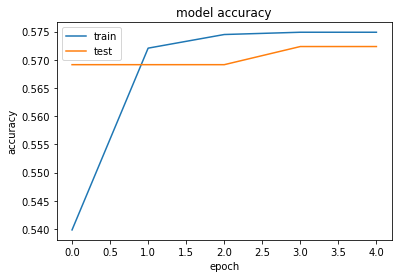

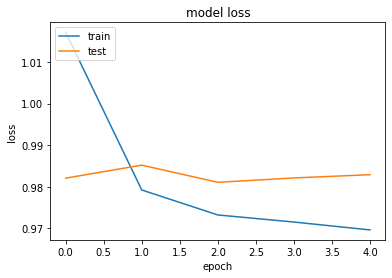

accuracy_score is  57.23%
balanced_accuracy_score is  33.24%
f1_score is  41.83%
roc_auc_score is  54.76%
recall_score is  57.23%
precision_score is  32.96%



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# effectiveness

In [ ]:
def mapping(lst, two, one, zero):
  mapped = []
  for i in range(len(lst)):
      s = lst[i]
      if s in two:
        mapped.append(2)
      elif s in one:
        mapped.append(1)
      elif s in zero:
        mapped.append(0)
      else:
        ValueError('!!!')

  return mapped

In [ ]:
np.unique(effectiveness)

array(['Considerably Effective', 'Highly Effective', 'Ineffective',
       'Marginally Effective', 'Moderately Effective'], dtype='<U22')

In [ ]:
two = ['Considerably Effective', 'Highly Effective']
one = ['Marginally Effective', 'Moderately Effective']
zero = ['Ineffective']

effectiveness = mapping(effectiveness, two, one, zero)
train_un = np.unique(effectiveness)
train_un

array([0, 1, 2])

In [ ]:
from sklearn.preprocessing import label_binarize
ya = label_binarize(effectiveness, classes=train_un)
ya.shape

(3107, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_list, ya, test_size=0.2, random_state = 45)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
len(words_to_index)

17894

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=MAX_SIZE, weights = [emb_matrix], trainable=False)

# **LSTM**

In [ ]:
model = lstm(vocab_len, emb_matrix)
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 100)         1789400   
                                                                 
 lstm_10 (LSTM)              (None, 64)                42240     
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dense_35 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,835,995
Trainable params: 46,595
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=MAX_SIZE, padding='post')

X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_SIZE, padding='post')

In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 20s 418ms/step - loss: 1.0524 - accuracy: 0.5235 - val_loss: 1.0185 - val_accuracy: 0.6817
Epoch 2/5
39/39 [==============================] - 16s 403ms/step - loss: 1.0012 - accuracy: 0.6893 - val_loss: 0.9705 - val_accuracy: 0.7267
Epoch 3/5
39/39 [==============================] - 16s 406ms/step - loss: 0.9586 - accuracy: 0.7175 - val_loss: 0.9296 - val_accuracy: 0.7283
Epoch 4/5
39/39 [==============================] - 16s 405ms/step - loss: 0.9236 - accuracy: 0.7235 - val_loss: 0.8943 - val_accuracy: 0.7283
Epoch 5/5
39/39 [==============================] - 16s 410ms/step - loss: 0.8911 - accuracy: 0.7243 - val_loss: 0.8640 - val_accuracy: 0.7331


In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_SIZE, padding='post')

model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 45ms/step - loss: 0.8640 - accuracy: 0.7331


[0.8639524579048157, 0.7331189513206482]

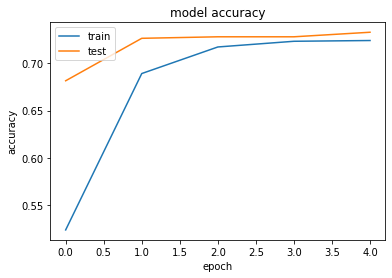

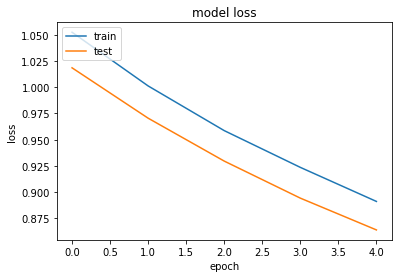

accuracy_score is  73.31%
balanced_accuracy_score is  33.26%
f1_score is  62.16%
roc_auc_score is  52.23%
recall_score is  73.31%
precision_score is  53.95%



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# **Simple RNN**

In [ ]:
model = rnn()
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 200, 100)          1789400   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_40 (Dense)            (None, 10)                330       
                                                                 
 dense_41 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,794,019
Trainable params: 4,619
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 4s 92ms/step - loss: 1.1962 - accuracy: 0.1034 - val_loss: 1.0493 - val_accuracy: 0.1125
Epoch 2/5
39/39 [==============================] - 2s 60ms/step - loss: 1.0030 - accuracy: 0.6757 - val_loss: 0.9436 - val_accuracy: 0.7122
Epoch 3/5
39/39 [==============================] - 2s 45ms/step - loss: 0.9235 - accuracy: 0.7010 - val_loss: 0.8898 - val_accuracy: 0.7251
Epoch 4/5
39/39 [==============================] - 2s 44ms/step - loss: 0.8887 - accuracy: 0.7054 - val_loss: 0.8631 - val_accuracy: 0.7267
Epoch 5/5
39/39 [==============================] - 2s 44ms/step - loss: 0.8659 - accuracy: 0.7111 - val_loss: 0.8418 - val_accuracy: 0.7299


In [ ]:
model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 0s 13ms/step - loss: 0.8418 - accuracy: 0.7299


[0.841812789440155, 0.729903519153595]

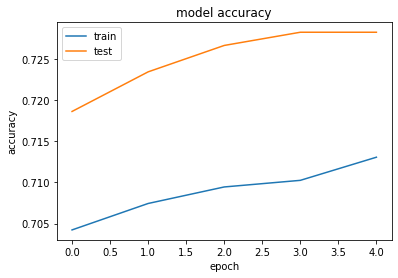

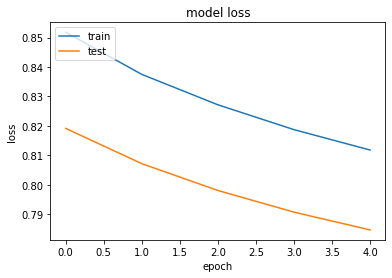

accuracy_score is  72.83%
balanced_accuracy_score is  33.65%
f1_score is  62.35%
roc_auc_score is  49.52%
recall_score is  72.83%
precision_score is  55.05%



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# **GRU**

In [ ]:
model = gru()
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 200, 100)          1789400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               25728     
 nal)                                                            
                                                                 
 dense_38 (Dense)            (None, 10)                650       
                                                                 
 dense_39 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,815,811
Trainable params: 26,411
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 12s 191ms/step - loss: 0.9368 - accuracy: 0.6873 - val_loss: 0.8803 - val_accuracy: 0.7251
Epoch 2/5
39/39 [==============================] - 7s 172ms/step - loss: 0.8590 - accuracy: 0.7211 - val_loss: 0.8283 - val_accuracy: 0.7347
Epoch 3/5
39/39 [==============================] - 6s 166ms/step - loss: 0.8254 - accuracy: 0.7243 - val_loss: 0.8064 - val_accuracy: 0.7347
Epoch 4/5
39/39 [==============================] - 6s 166ms/step - loss: 0.8100 - accuracy: 0.7243 - val_loss: 0.7946 - val_accuracy: 0.7347
Epoch 5/5
39/39 [==============================] - 7s 171ms/step - loss: 0.8005 - accuracy: 0.7247 - val_loss: 0.7867 - val_accuracy: 0.7347


In [ ]:
model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 31ms/step - loss: 0.7867 - accuracy: 0.7347


[0.7866632342338562, 0.7347266674041748]

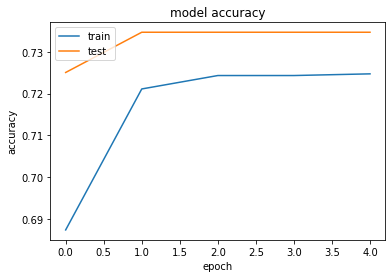

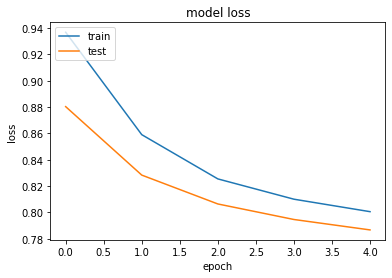

accuracy_score is  73.47%
balanced_accuracy_score is  33.33%
f1_score is  62.24%
roc_auc_score is  46.69%
recall_score is  73.47%
precision_score is  53.98%



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# sideEffects

In [ ]:
np.unique(sideEffects)

array(['Extremely Severe Side Effects', 'Mild Side Effects',
       'Moderate Side Effects', 'No Side Effects', 'Severe Side Effects'],
      dtype='<U29')

In [ ]:
two = ['Extremely Severe Side Effects', 'Severe Side Effects']
one = ['Moderate Side Effects', 'Mild Side Effects']
zero = ['No Side Effects']

sideEffects = mapping(sideEffects, two, one, zero)
train_un = np.unique(sideEffects)
train_un

array([0, 1, 2])

In [ ]:
from sklearn.preprocessing import label_binarize
ya = label_binarize(sideEffects, classes=train_un)
ya.shape

(3107, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_list, ya, test_size=0.2, random_state = 45)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
len(words_to_index)

17894

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=MAX_SIZE, weights = [emb_matrix], trainable=False)

# **LSTM**

In [ ]:
model = lstm(vocab_len, emb_matrix)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         1789400   
                                                                 
 lstm_9 (LSTM)               (None, 64)                42240     
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,835,995
Trainable params: 46,595
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=MAX_SIZE, padding='post')

X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_SIZE, padding='post')

In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 23s 514ms/step - loss: 1.1493 - accuracy: 0.2241 - val_loss: 1.1216 - val_accuracy: 0.2653
Epoch 2/5
39/39 [==============================] - 16s 401ms/step - loss: 1.1025 - accuracy: 0.3123 - val_loss: 1.0880 - val_accuracy: 0.3891
Epoch 3/5
39/39 [==============================] - 15s 396ms/step - loss: 1.0741 - accuracy: 0.4414 - val_loss: 1.0670 - val_accuracy: 0.4695
Epoch 4/5
39/39 [==============================] - 16s 415ms/step - loss: 1.0534 - accuracy: 0.5042 - val_loss: 1.0530 - val_accuracy: 0.4936
Epoch 5/5
39/39 [==============================] - 15s 395ms/step - loss: 1.0403 - accuracy: 0.5211 - val_loss: 1.0438 - val_accuracy: 0.5048


In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_SIZE, padding='post')

model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 50ms/step - loss: 1.0438 - accuracy: 0.5048


[1.0437591075897217, 0.5048231482505798]

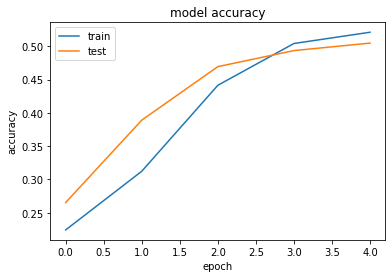

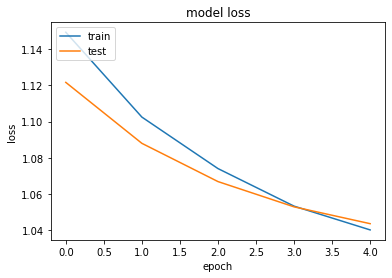

accuracy_score is  50.48%
balanced_accuracy_score is  33.19%
f1_score is  34.44%
roc_auc_score is  46.28%
recall_score is  50.48%
precision_score is  32.18%



In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# **Simple RNN**

In [ ]:
model = rnn()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 200, 100)          1789400   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_30 (Dense)            (None, 10)                330       
                                                                 
 dense_31 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,794,019
Trainable params: 4,619
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 3s 54ms/step - loss: 1.1123 - accuracy: 0.1807 - val_loss: 1.1135 - val_accuracy: 0.1785
Epoch 2/5
39/39 [==============================] - 2s 44ms/step - loss: 1.1060 - accuracy: 0.4298 - val_loss: 1.1075 - val_accuracy: 0.4727
Epoch 3/5
39/39 [==============================] - 2s 45ms/step - loss: 1.1017 - accuracy: 0.4994 - val_loss: 1.1049 - val_accuracy: 0.4727
Epoch 4/5
39/39 [==============================] - 2s 44ms/step - loss: 1.0989 - accuracy: 0.4994 - val_loss: 1.1023 - val_accuracy: 0.4759
Epoch 5/5
39/39 [==============================] - 2s 45ms/step - loss: 1.0961 - accuracy: 0.5002 - val_loss: 1.0998 - val_accuracy: 0.4759


In [ ]:
model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 0s 12ms/step - loss: 1.0998 - accuracy: 0.4759


[1.099819540977478, 0.47588425874710083]

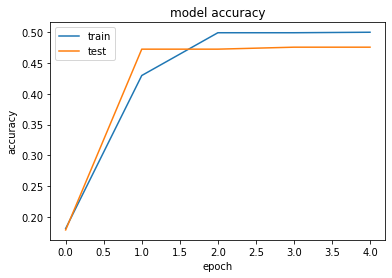

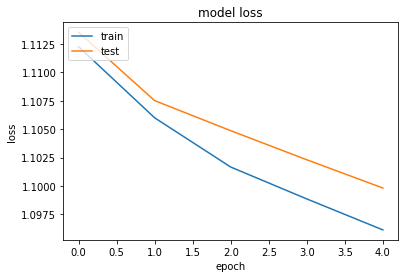

accuracy_score is  47.59%
balanced_accuracy_score is  32.41%
f1_score is  35.57%
roc_auc_score is  48.68%
recall_score is  47.59%
precision_score is  34.81%



In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

# **GRU**

In [ ]:
model = gru()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 200, 100)          1789400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               25728     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 10)                650       
                                                                 
 dense_33 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,815,811
Trainable params: 26,411
Non-trainable params: 1,789,400
_________________________________________________________________


In [ ]:
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5, validation_data=(X_test_indices, Y_test))

Epoch 1/5
39/39 [==============================] - 11s 192ms/step - loss: 1.3646 - accuracy: 0.2797 - val_loss: 1.2189 - val_accuracy: 0.2894
Epoch 2/5
39/39 [==============================] - 10s 262ms/step - loss: 1.1669 - accuracy: 0.2829 - val_loss: 1.1196 - val_accuracy: 0.3087
Epoch 3/5
39/39 [==============================] - 6s 167ms/step - loss: 1.0928 - accuracy: 0.3549 - val_loss: 1.0788 - val_accuracy: 0.3746
Epoch 4/5
39/39 [==============================] - 7s 167ms/step - loss: 1.0595 - accuracy: 0.4390 - val_loss: 1.0599 - val_accuracy: 0.4469
Epoch 5/5
39/39 [==============================] - 7s 184ms/step - loss: 1.0438 - accuracy: 0.4841 - val_loss: 1.0504 - val_accuracy: 0.4695


In [ ]:
model.evaluate(X_test_indices, Y_test)

20/20 [==============================] - 1s 28ms/step - loss: 1.0504 - accuracy: 0.4695


[1.0503815412521362, 0.469453364610672]

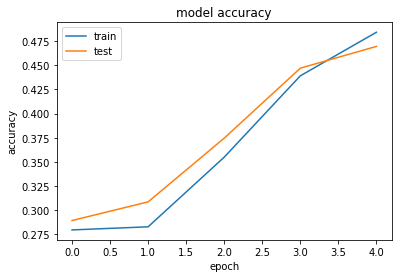

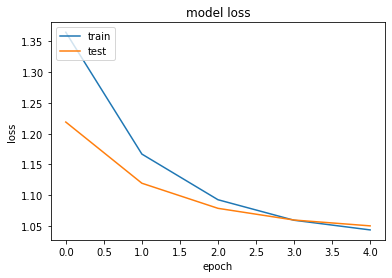

accuracy_score is  46.95%
balanced_accuracy_score is  31.90%
f1_score is  35.78%
roc_auc_score is  46.01%
recall_score is  46.95%
precision_score is  38.28%



In [ ]:
y_true_matrix = Y_test
y_pred_matrix = model.predict(X_test_indices)

report(history, y_true_matrix, y_pred_matrix)

З результатів, отриманих в ході виконання лабораторної роботи, можна зробити висновок, що найефективнішими моделями для рейтингу виявились LSTM та GRU, при чому їхні точності практично однакові. Щодо ефектифності, то тут вже не було розбіжностей — усі моделі ефективні. З побічними ефектами картина зовсім інша, ніж з ефективністю. Тут найефективнішою є LSTM модель. 


